**Tip1：model只演化瞬态，但是按一定规则将模型瞬态存储在硬盘中！不要在内存中生成巨大的数组，而是将数据保存在硬盘后再读取和处理**

**Tip2：四邻域的周期边界条件与八邻域的周期边界条件不一致，四邻域的周期边界条件需要处理空间的四条边界，而八邻域的周期边界条件除了需要处理四邻域的情况外还需要处理空间的四个顶点。我在Ricker2D模型中只计算了上下左右四个邻域（即采用了四邻域的周期边界条件），但是所写的程序是为了八邻域的周期边界条件准备的**

**Rick2D的非numba版本的python code，测试版，主要为了练手熟悉python**

In [14]:
import numpy as np
import math

Burntime=np.int(2e+2)
T=np.int(2e+3)  # Time steps
L=64
M=L # The row of lattice 
N=L # The column of lattice
LF=0.1 
z=4 
r=2.3  
B=0.12 
GF=1 - LF 
dt=200 # Sample interval
#SamNum=np.int(T/dt) # Number of samples。这个是典型的不适合大量在内存中存储数据的例子
#Sample=np.empty((SamNum,M,N)) #M,N为空间行与列，SamNum为垂向维。这个是典型的不适合大量在内存中存储数据的例子

#初始化model的状态矩阵
modelstate=np.empty((M,N))
MU=0.5
SIGMA=0.1
for i in range(M):
    for j in range(N):
        R1=np.random.normal(0.5,0.1)
        while R1<0:
            R1=np.random.normal(0.5,0.1)
        modelstate[i,j]=R1

#初始化model的演化矩阵
modelevolution=np.empty((M+2,N+2))
modelevolution[1:M+1,1:N+1]=modelstate #牢记矩阵取地址时[1:M+1]表示从索引为1的地址开始取到索引为M的地址
#周期边界条件
modelevolution[0,1:N+1]=modelstate[M-1,:]
modelevolution[M+1,1:N+1]=modelstate[0,:] 
modelevolution[1:N+1,0]=modelstate[:,N-1] 
modelevolution[1:N+1,N+1]=modelstate[:,0]
modelevolution[0,0]=modelstate[M-1,N-1]
modelevolution[0,N+1]=modelstate[M-1,0]
modelevolution[M+1,0]=modelstate[0,N-1]
modelevolution[M+1,N+1]=modelstate[0,0]
#生成循环体内的运算矩阵
PreModelstate=modelstate
PostModelstate=modelstate
PreModelevolution=modelevolution
PostModelevolution=modelevolution

for k in range(Burntime+T): #time loop，记得loop和if都要有冒号
    PreModelstate=PostModelstate
    PreModelevolution=PostModelevolution
    #Generate noise, which are uncorrelated in both space and time
    #噪音同样具备周期性边界条件
    stateNoise=np.random.randn(M,N)
    evolutionNoise=np.empty((M+2,N+2))
    evolutionNoise[1:M+1,1:N+1]=stateNoise
    evolutionNoise[0,1:N+1]=stateNoise[M-1,:]
    evolutionNoise[M+1,1:N+1]=stateNoise[0,:] 
    evolutionNoise[1:N+1,0]=stateNoise[:,N-1] 
    evolutionNoise[1:N+1,N+1]=stateNoise[:,0]
    evolutionNoise[0,0]=stateNoise[M-1,N-1]
    evolutionNoise[0,N+1]=stateNoise[M-1,0]
    evolutionNoise[M+1,0]=stateNoise[0,N-1]
    evolutionNoise[M+1,N+1]=stateNoise[0,0]
    
    for i in range(1,M+1):
        for j in range(1,N+1):
            #寻找model上每个格点的邻居
            North=PreModelevolution[i-1,j] #这里和matlab一样，会取出一个数，若要取出一个数组，则必须np.array([Cmodelevolution[0,i-1,j]]),这样就是一个元素的数组
            South=PreModelevolution[i+1,j]
            East=PreModelevolution[i,j+1]
            West=PreModelevolution[i,j-1]
            Neighbour=np.array([North,South,East,West])
            #寻找noise上每个格点的邻居
            North1=evolutionNoise[i-1,j]
            South1=evolutionNoise[i+1,j]
            East1=evolutionNoise[i,j+1]
            West1=evolutionNoise[i,j-1]
            Neighbour1=np.array([North1,South1,East1,West1])
            #模型演化的核心部分
            GlobalChange=PreModelevolution[i,j]*math.exp(r*(1-PreModelevolution[i,j]))*(1 + B*evolutionNoise[i,j]) #这里python的exp为标准库math的exp
            NeighbourChange=np.sum(Neighbour*np.exp(r*(1-Neighbour))*(1 + B*Neighbour1)) #这里python的exp为numpy的exp，也可以用array.sum()
            PostModelevolution[i,j]=GF*GlobalChange+(LF/z)*NeighbourChange
    #更新模型状态
    PostModelstate=PostModelevolution[1:M+1,1:N+1]
    #周期边界条件
    PostModelevolution[0,1:N+1]=PostModelstate[M-1,:]
    PostModelevolution[M+1,1:N+1]=PostModelstate[0,:] 
    PostModelevolution[1:N+1,0]=PostModelstate[:,N-1] 
    PostModelevolution[1:N+1,N+1]=PostModelstate[:,0]
    PostModelevolution[0,0]=PostModelstate[M-1,N-1]
    PostModelevolution[0,N+1]=PostModelstate[M-1,0]
    PostModelevolution[M+1,0]=PostModelstate[0,N-1]
    PostModelevolution[M+1,N+1]=PostModelstate[0,0]

#model只演化瞬态，但是按一定规则将模型瞬态存储在硬盘中！不要在内存中生成巨大的数组，而是将数据保存在硬盘后再读取和处理

end


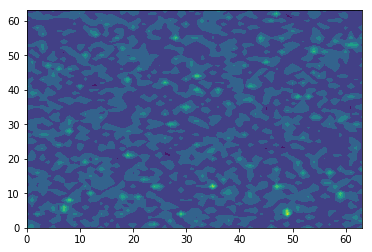

In [19]:
import matplotlib.pyplot as plt
plt.contourf(Cmodelstate[1,:,:])

**Rick2D的numba_CPU版本的python code，基于CPU并行的优化**

In [54]:
from numba import jit,prange,stencil  #牢记prange也要导入
import numpy as np
import math

@jit(nopython=True,parallel=True)
def model_initial_state(MatA,MU,SIGMA): #MatA必须是一个numpy的array，MU和SIGMA分别表示高斯分布的均值与标准差
    row,col=MatA.shape #获取MatA的维度，并存于元组tuple
    for i in prange(row):
        for j in prange(col):
            RN=always_large_0(MU,SIGMA)
            MatA[i,j]=RN
    return MatA
    
@jit(nopython=True)
def always_large_0(MU,SIGMA):
    a=np.random.normal(MU,SIGMA)
    while a<0:
        a=np.random.normal(MU,SIGMA)
    return a

@jit(nopython=True)
def model_initial_evolution(MatB): #利用模型状态矩阵填充模型演化矩阵边界以外的区域
    row,col=MatB.shape
    MatA=np.empty((row+2,col+2))
    MatA[1:row+1,1:col+1]=MatB
    return MatA

@jit(nopython=True)
def model_evolution_update(MatA): #利用模型演化矩阵更新模型状态矩阵
    row,col=MatA.shape
    row=row-2
    col=col-2
    MatB=np.empty((row,col))
    MatB=MatA[1:row+1,1:col+1]
    return MatB

@jit(nopython=True) 
def periodic_boundary_condition(MatA,MatB): #利用模型状态矩阵边界填充模型演化矩阵的边界，实现周期边界条件
    row,col=MatB.shape
    MatA[0,1:col+1]=MatB[row-1,:]
    MatA[row+1,1:col+1]=MatB[0,:] 
    MatA[1:col+1,0]=MatB[:,col-1] 
    MatA[1:col+1,col+1]=MatB[:,0]
    MatA[0,0]=MatB[row-1,col-1]
    MatA[0,col+1]=MatB[row-1,0]
    MatA[row+1,0]=MatB[0,col-1]
    MatA[row+1,col+1]=MatB[0,0]
    return MatA

@jit(nopython=True)
def model_noise(row,col): #生成模型的噪音矩阵
    MatB=np.random.randn(row,col)
    MatA=model_initial_evolution(MatB)
    MatA=periodic_boundary_condition(MatA,MatB)
    return MatA

@stencil
def kernel_Global(MatA,MatB,par1,par2): #计算每个点受到的全局影响，MatA为模型演化矩阵，MatB为噪音矩阵，以点的视角编程
    return MatA[0,0]*math.exp(par1*(1-MatA[0,0]))*(1+par2*MatB[0,0])

@stencil
def kernel_Neighbour(MatA,MatB,par1,par2): #计算每个点受到的邻居影响，MatA为模型演化矩阵，MatB为噪音矩阵，以点的视角编程
    North=MatA[-1,0]*math.exp(par1*(1-MatA[-1,0]))*(1+par2*MatB[-1,0])
    South=MatA[1,0]*math.exp(par1*(1-MatA[1,0]))*(1+par2*MatB[1,0])
    East=MatA[0,1]*math.exp(par1*(1-MatA[0,1]))*(1+par2*MatB[0,1])
    West=MatA[0,-1]*math.exp(par1*(1-MatA[0,-1]))*(1+par2*MatB[0,-1])
    return North+South+East+West

In [ ]:
Burntime=np.int(2e+2)
T=np.int(2e+3)  # Time steps
L=64
M=L # The row of lattice 
N=L # The column of lattice
LF=0.1 
z=4.0 
r=2.3  
B=0.12 
GF=1-LF
LFR=LF/z
dt=200 # Sample interval

#初始化model的状态矩阵
modelstate=np.empty((M,N))
MU=0.5
SIGMA=0.1
modelstate=model_initial_state(modelstate,MU,SIGMA)

#初始化model的演化矩阵
modelevolution=model_initial_evolution(modelstate)

#周期边界条件
modelevolution=periodic_boundary_condition(modelevolution,modelstate)

#生成循环体内的运算矩阵
PreModelstate=modelstate
PostModelstate=modelstate
PreModelevolution=modelevolution
PostModelevolution=modelevolution

for k in range(Burntime+T): #time loop，记得loop和if都要有冒号
    PreModelstate=PostModelstate
    PreModelevolution=PostModelevolution
    #Generate noise, which are uncorrelated in both space and time
    #噪音同样具备周期性边界条件
    evolutionNoise=model_noise(M,N)
    #在空间上对模型进行计算
    GlobalChange=kernel_Global(PreModelevolution,evolutionNoise,r,B) #GlobalChange是与PreModelevolution尺寸一样大的stencil输出矩阵，这个计算完后边界上是有数字的（边界也要计算）
    NeighbourChange=kernel_Neighbour(PreModelevolution,evolutionNoise,r,B) #GlobalChange是与PreModelevolution尺寸一样大的stencil输出矩阵，这个计算完后边界上是0
    PostModelevolution=GF*GlobalChange+LFR*NeighbourChange #这里也可以用numpy.add这个method实现矩阵相加。注意，PostModelevolution边界上的数值是不对的
    #更新模型状态
    PostModelstate=model_evolution_update(PostModelevolution)
    #周期边界条件
    PostModelevolution=periodic_boundary_condition(PostModelevolution,PostModelstate)

**Rick2D的numba_GPU版本的python code，基于CUDA PYTHON并行的优化**

In [1]:
from numba import jit,prange,cuda,vectorize,float32,float64 #牢记prange也要导入
import numpy as np
import math
import cupy

@jit(nopython=True,parallel=True)
def model_initial_state(MatA,MU,SIGMA): #MatA必须是一个numpy的array，MU和SIGMA分别表示高斯分布的均值与标准差
    row,col=MatA.shape #获取MatA的维度，并存于元组tuple
    for i in prange(row):
        for j in prange(col):
            RN=always_large_0(MU,SIGMA)
            MatA[i,j]=RN
    return MatA
    
@jit(nopython=True)
def always_large_0(MU,SIGMA):
    a=np.random.normal(MU,SIGMA)
    while a<0:
        a=np.random.normal(MU,SIGMA)
    return a

@jit(nopython=True)
def model_initial_evolution(MatB): #利用模型状态矩阵填充模型演化矩阵边界以外的区域
    row,col=MatB.shape
    MatA=np.empty((row+2,col+2),dtype=np.float32)
    MatA[1:row+1,1:col+1]=MatB
    return MatA

@jit(nopython=True)
def model_evolution_update(MatA): #利用模型演化矩阵更新模型状态矩阵
    row,col=MatA.shape
    row=row-2
    col=col-2
    MatB=np.empty((row,col),dtype=np.float32)
    MatB=MatA[1:row+1,1:col+1]
    return MatB

@jit(nopython=True) 
def periodic_boundary_condition(MatA,MatB): #利用模型状态矩阵边界填充模型演化矩阵的边界，实现周期边界条件
    row,col=MatB.shape
    MatA[0,1:col+1]=MatB[row-1,:]
    MatA[row+1,1:col+1]=MatB[0,:] 
    MatA[1:col+1,0]=MatB[:,col-1] 
    MatA[1:col+1,col+1]=MatB[:,0]
    MatA[0,0]=MatB[row-1,col-1]
    MatA[0,col+1]=MatB[row-1,0]
    MatA[row+1,0]=MatB[0,col-1]
    MatA[row+1,col+1]=MatB[0,0]
    return MatA

@jit(nopython=True) #这个也可以用cuda改一下！虽然不一定需要改。
def model_noise(row,col): #生成模型的噪音矩阵
    MatB=np.random.randn(row,col).astype(np.float32)
    MatA=model_initial_evolution(MatB)
    MatA=periodic_boundary_condition(MatA,MatB)
    return MatA

@vectorize(["float32(float32,float32,float32,float32)","float64(float64,float64,float64,float64)"],target='cuda')
def kernel_Global(x,y,par1,par2):
    return x*math.exp(par1*(1-x))*(1+par2*y)

@vectorize(["float32(float32,float32,float32,float32)","float64(float64,float64,float64,float64)"],target='cuda')
def kernel_add(x,y,par1,par2):
    return x*par1+y*par2

#@cuda.jit(device=True)
#def device_fun1(x,y,par1,par2): 
#    a=x*math.exp(par1*(1-x))*(1+par2*y)
#    a=float32(a)
#    return a

@cuda.jit
def kernel_pbc(MatA): 
    x,y=cuda.grid(2)
    row1,col1=MatA.shape
    if x==0:
        MatA[x,y]=MatA[row1-2,y]
    elif x==row1-1:
        MatA[x,y]=MatA[1,y]
    elif y==0:
        MatA[x,y]=MatA[x,col1-2]
    elif y==col1-1:
        MatA[x,y]=MatA[x,1]
    else:
        MatA[x,y]=MatA[x,y]

@cuda.jit
def kernel_Neighbour(MatA,MatB,par1,par2,MatC):
    x,y=cuda.grid(2)
    if (x>0) and (x<MatA.shape[0]-1) and (y>0) and (y<MatA.shape[1]-1):
         MatC[x,y]=MatA[x-1,y]*math.exp(par1*(1-MatA[x-1,y]))*(1+par2*MatB[x-1,y])+\
         MatA[x+1,y]*math.exp(par1*(1-MatA[x+1,y]))*(1+par2*MatB[x+1,y])+\
         MatA[x,y+1]*math.exp(par1*(1-MatA[x,y+1]))*(1+par2*MatB[x,y+1])+\
         MatA[x,y-1]*math.exp(par1*(1-MatA[x,y-1]))*(1+par2*MatB[x,y-1])
#        MatC[x,y]=device_fun1(MatA[x-1,y],MatB[x-1,y],par1,par2)
#        +device_fun1(MatA[x+1,y],MatB[x+1,y],par1,par2)+
#        device_fun1(MatA[x,y+1],MatB[x,y+1],par1,par2)+device_fun1(MatA[x,y-1],MatB[x,y-1],par1,par2)

@cuda.jit
def kernel_compute(MatA,MatB,par1,par2,par3,par4,MatC): #MatA是Modelevolution_device，MatB是Noise_device，par1和par2分别是r和B，par3和par4分别是GF和LFR
    x,y=cuda.grid(2)                               #这个kernel有问题
    row2,col2=MatA.shape
#    GlobalChange=MatA[x,y]*math.exp(par1*(1-MatA[x,y]))*(1+par2*MatB[x,y])
    if (x>0) and (x<row2-1) and (y>0) and (y<col2-1): 
        GlobalChange=MatA[x,y]*math.exp(par1*(1-MatA[x,y]))*(1+par2*MatB[x,y])
        NeighbourChange=MatA[x-1,y]*math.exp(par1*(1-MatA[x-1,y]))*(1+par2*MatB[x-1,y])+\
        MatA[x+1,y]*math.exp(par1*(1-MatA[x+1,y]))*(1+par2*MatB[x+1,y])+\
        MatA[x,y+1]*math.exp(par1*(1-MatA[x,y+1]))*(1+par2*MatB[x,y+1])+\
        MatA[x,y-1]*math.exp(par1*(1-MatA[x,y-1]))*(1+par2*MatB[x,y-1])
        MatC[x,y]=GlobalChange*par3+NeighbourChange*par4

In [2]:
#CUDA程序的编写必须分清代码哪些部分在CPU上执行，代码哪些部分在GPU上执行，注意CPU与GPU的同步！
#CUDA程序必须严格确定每个变量的数据类型，保证变量在GPU上运行代码时计算时的数据类型保持一致！回到了C的感觉
Burntime=int(0)
T=int(500)  # Time steps
L=int(512)
M=L # The row of lattice 
N=L # The column of lattice
LF=0.1 #牢记，输入GPU的标量不需要执行.to_device的操作，这种操作会导致错误！！！
z=4.0
r=2.3
B=0.12
GF=1-LF
LFR=LF/z
#dt=np.int(200) # Sample interval

#初始化model的状态矩阵
modelstate=np.empty((M-2,N-2),dtype=np.float32)
MU=float32(0.5)
SIGMA=float32(0.1)
modelstate=model_initial_state(modelstate,MU,SIGMA)
#初始化model的演化矩阵
modelevolution=model_initial_evolution(modelstate)
#周期边界条件
modelevolution=periodic_boundary_condition(modelevolution,modelstate)
#生成循环体内的运算矩阵
PreModelstate=modelstate
PostModelstate=modelstate
PreModelevolution=modelevolution
PostModelevolution=modelevolution
#提前分配好GPU的内存给用于GPU计算的array
evolutionNoise_device=cupy.empty(shape=(M,N),dtype=np.float32)
GlobalChange_device=cuda.device_array(shape=(M,N),dtype=np.float32) #类似np.empty
NeighbourChange_device=cuda.device_array(shape=(M,N),dtype=np.float32)
PostModelevolution_device=cuda.device_array(shape=(M,N),dtype=np.float32)
#生成CUDA的计算网格，即对grid，block和thread设置参数
threadsperblock=(32,32) #这个设定要根据显卡类型决定！我目前的显卡的block内的线程只能支持到32
blockspergrid_x=math.ceil(PreModelevolution.shape[0]/threadsperblock[0])
blockspergrid_y=math.ceil(PreModelevolution.shape[1]/threadsperblock[1])
blockspergrid=(blockspergrid_x,blockspergrid_y)
#进入循环前必须确保矩阵内所有元素和与矩阵元素进行运算的参数的数据类型一致，这里使用np.float32
for k in range(Burntime+T):
    #这部分开始在CPU上执行
    PreModelstate=PostModelstate
    PreModelevolution=PostModelevolution
    PreModelevolution_device=cuda.to_device(PreModelevolution)
    #Generate noise, which are uncorrelated in both space and time
    #噪音同样具备周期性边界条件
#    evolutionNoise=model_noise(M-2,N-2)
    evolutionNoise_device=cupy.random.randn(M,N,dtype=np.float32)
    kernel_pbc[blockspergrid,threadsperblock](evolutionNoise_device)
#    evolutionNoise_device[0,:]=evolutionNoise_device[M-2,:]
#    evolutionNoise_device[M-1,:]=evolutionNoise_device[1,:]
#    evolutionNoise_device[:,0]=evolutionNoise_device[:,N-2]
#    evolutionNoise_device[:,N-1]=evolutionNoise_device[:,1]
#    evolutionNoise_device[0,0]=evolutionNoise_device[M-2,N-2]
#    evolutionNoise_device[0,N-1]=evolutionNoise_device[M-2,1]
#    evolutionNoise_device[M-1,0]=evolutionNoise_device[1,N-2]
#    evolutionNoise_device[M-1,N-1]=evolutionNoise_device[1,1]
    #这部分开始是在GPU上进行的，将数据拷贝至GPU的内存
#    PreModelevolution_device=cuda.to_device(PreModelevolution)
#    evolutionNoise_device=cuda.to_device(evolutionNoise)
#    cuda.synchronize() #强制CPU等GPU，实现同步
    #在空间上对模型进行计算
    #kernel_Global是@vectorize
#    kernel_Global(PreModelevolution_device,evolutionNoise_device,r,B,out=GlobalChange_device)
    #kernel_Neighbour是@cuda.jit
#    kernel_Neighbour[blockspergrid,threadsperblock](PreModelevolution_device,evolutionNoise_device,r,B,NeighbourChange_device) 
    #kernel_add是@vectorize
#    kernel_add(GlobalChange_device,NeighbourChange_device,GF,LFR,out=PostModelevolution_device)

    kernel_compute[blockspergrid,threadsperblock](PreModelevolution_device,evolutionNoise_device,r,B,GF,LFR,PostModelevolution_device)
    #把在GPU上计算好的array拷贝回CPU
#    PostModelevolution_device=PreModelevolution_device
    PostModelevolution=PostModelevolution_device.copy_to_host()

    #这部分开始在CPU上执行，更新模型状态
    #    #下面这两个矩阵的相加是使用numpy的ufunc，不知道使用@vectorize是否更快
    #    PostModelevolution=GF*GlobalChange+LFR*NeighbourChange #这里也可以用numpy.add这个method实现矩阵相加。
    PostModelstate=model_evolution_update(PostModelevolution)
    #周期边界条件
    PostModelevolution=periodic_boundary_condition(PostModelevolution,PostModelstate)

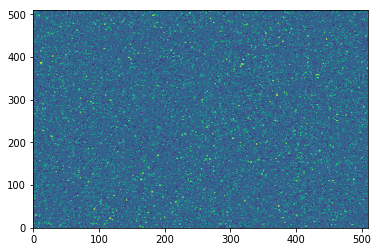

In [4]:
import matplotlib.pyplot as plt
fig=plt.figure()
plt.contourf(PostModelstate)
plt.show()

**Rick2D的numba_GPU版本的进阶版python code，基于CUDA PYTHON并行的深度优化**

In [1]:
from numba import jit,prange,cuda,vectorize,float32,float64 #牢记prange也要导入
import numpy as np
import math
import cupy

@jit(nopython=True,parallel=True)
def model_initial_state(MatA,MU,SIGMA): #MatA必须是一个numpy的array，MU和SIGMA分别表示高斯分布的均值与标准差
    row,col=MatA.shape #获取MatA的维度，并存于元组tuple
    for i in prange(row):
        for j in prange(col):
            RN=always_large_0(MU,SIGMA)
            MatA[i,j]=RN
    return MatA
    
@jit(nopython=True)
def always_large_0(MU,SIGMA):
    a=np.random.normal(MU,SIGMA)
    while a<0:
        a=np.random.normal(MU,SIGMA)
    return a

@jit(nopython=True) 
def model_initial_evolution(MatB): #利用模型状态矩阵填充模型演化矩阵边界以外的区域
    row,col=MatB.shape
    MatA=np.empty((row+2,col+2),dtype=np.float32)
    MatA[1:row+1,1:col+1]=MatB
    return MatA

@jit(nopython=True)
def model_evolution_update(MatA): #利用模型演化矩阵更新模型状态矩阵
    row,col=MatA.shape
    row=row-2
    col=col-2
    MatB=np.empty((row,col),dtype=np.float32)
    MatB=MatA[1:row+1,1:col+1]
    return MatB

@jit(nopython=True) 
def periodic_boundary_condition(MatA,MatB): #利用模型状态矩阵边界填充模型演化矩阵的边界，实现周期边界条件
    row,col=MatB.shape
    MatA[0,1:col+1]=MatB[row-1,:]
    MatA[row+1,1:col+1]=MatB[0,:] 
    MatA[1:col+1,0]=MatB[:,col-1] 
    MatA[1:col+1,col+1]=MatB[:,0]
    MatA[0,0]=MatB[row-1,col-1]
    MatA[0,col+1]=MatB[row-1,0]
    MatA[row+1,0]=MatB[0,col-1]
    MatA[row+1,col+1]=MatB[0,0]
    return MatA

@jit(nopython=True) #这个也可以用cuda改一下！这样循环体就可以彻底在GPU上执行，但numba的cuda.jit目前（0.43版本）无法编译cupy的函数
def model_noise(row,col): #生成模型的噪音矩阵
    MatB=np.random.randn(row,col).astype(np.float32)
    MatA=model_initial_evolution(MatB)
    MatA=periodic_boundary_condition(MatA,MatB)
    return MatA

@vectorize(["float32(float32,float32,float32,float32)","float64(float64,float64,float64,float64)"],target='cuda')
def kernel_Global(x,y,par1,par2):
    return x*math.exp(par1*(1-x))*(1+par2*y)

@vectorize(["float32(float32,float32,float32,float32)","float64(float64,float64,float64,float64)"],target='cuda')
def kernel_add(x,y,par1,par2):
    return x*par1+y*par2

@cuda.jit
def kernel_Neighbour(MatA,MatB,par1,par2,MatC):
    x,y=cuda.grid(2)
    if (x>0) and (x<MatA.shape[0]-1) and (y>0) and (y<MatA.shape[1]-1):
         MatC[x,y]=MatA[x-1,y]*math.exp(par1*(1-MatA[x-1,y]))*(1+par2*MatB[x-1,y])+\
         MatA[x+1,y]*math.exp(par1*(1-MatA[x+1,y]))*(1+par2*MatB[x+1,y])+\
         MatA[x,y+1]*math.exp(par1*(1-MatA[x,y+1]))*(1+par2*MatB[x,y+1])+\
         MatA[x,y-1]*math.exp(par1*(1-MatA[x,y-1]))*(1+par2*MatB[x,y-1])

@cuda.jit
def kernel_noise(MatA):
    x,y=cuda.grid(2)
    row,col=MatA.shape
#    MatA=cupy.random.randn(M,N,dtype=np.float32)
    if (x>0) and (x<row-1):
        MatA[x,y]=cupy.random.randn(1,dtype=cupy.float32)
    elif x==0:
        MatA[x,y]=MatA[row-2,y]
    elif x==row-1:
        MatA[x,y]=MatA[1,y]
    elif y==0:
        MatA[x,y]=MatA[x,col-2]
    elif y==col-1:
        MatA[x,y]=MatA[x,1]
    
#    MatA[0,y]=MatA[row-2,y]
#    MatA[row-1,y]=MatA[1,y]
#    MatA[x,0]=MatA[x,col-2]
#    MatA[x,col-1]=MatA[x,1]
#    MatA[0,0]=MatA[row-2,col-2]
#    MatA[0,col-1]=MatA[row-2,1]
#    MatA[row-1,0]=MatA[1,col-2]
#    MatA[row-1,col-1]=MatA[1,1]

@cuda.jit(device=True)
def device_fun1(x,y,par1,par2): 
    a=x*math.exp(par1*(1-x))*(1+par2*y)
    return a    

@cuda.jit
def kernel_compute(MatA,MatB,par1,par2,par3,par4,MatC): #MatA是Modelevolution_device，MatB是Noise_device，par1和par2分别是r和B，par3和par4分别是GF和LFR
    x,y=cuda.grid(2)                               #这个kernel有问题，直接对MatA进行计算会导致错误
    row1,col1=MatA.shape
    if (x>0) and (x<row1-1) and (y>0) and (y<col1-1): #and (y>0) and (y<col-1)
        GlobalChange=MatA[x,y]*math.exp(par1*(1-MatA[x,y]))*(1+par2*MatB[x,y])
        NeighbourChange=MatA[x-1,y]*math.exp(par1*(1-MatA[x-1,y]))*(1+par2*MatB[x-1,y])+\
        MatA[x+1,y]*math.exp(par1*(1-MatA[x+1,y]))*(1+par2*MatB[x+1,y])+\
        MatA[x,y+1]*math.exp(par1*(1-MatA[x,y+1]))*(1+par2*MatB[x,y+1])+\
        MatA[x,y-1]*math.exp(par1*(1-MatA[x,y-1]))*(1+par2*MatB[x,y-1])
        MatC[x,y]=GlobalChange*par3+NeighbourChange*par4
    else:
        MatC[x,y]=MatA[x,y]
#    MatA[x,y]=MatC[x,y]
#    elif x==0:
#        MatA[x,y]=MatA[row1-2,y]
#    elif x==row1-1:
#        MatA[x,y]=MatA[1,y]
#    elif y==0:
#        MatA[x,y]=MatA[x,col1-2]
#    elif y==col1-1:
#        MatA[x,y]=MatA[x,1] 
        
#    elif x==0:
#        MatA[x,y]=MatA[row-2,y]
#    elif x==row-1:
#        MatA[x,y]=MatA[1,y]

#    MatA[0,y]=MatA[row-2,y]
#    MatA[row-1,y]=MatA[1,y]
#    MatA[x,0]=MatA[x,col-2]
#    MatA[x,col-1]=MatA[x,1]
#    MatA[0,0]=MatA[row-2,col-2]
#    MatA[0,col-1]=MatA[row-2,1]
#    MatA[row-1,0]=MatA[1,col-2]
#    MatA[row-1,col-1]=MatA[1,1]

@cuda.jit
def kernel_pbc(MatA): 
    x,y=cuda.grid(2)
    row2,col2=MatA.shape
    if x==0:
        MatA[x,y]=MatA[row2-2,y]
    elif x==row2-1:
        MatA[x,y]=MatA[1,y]
    elif y==0:
        MatA[x,y]=MatA[x,col2-2]
    elif y==col2-1:
        MatA[x,y]=MatA[x,1]
    else:
        MatA[x,y]=MatA[x,y]
#    MatA[0,0]=MatA[row-2,col-2]
#    MatA[0,col-1]=MatA[row-2,1]
#    MatA[row-1,0]=MatA[1,col-2]
#    MatA[row-1,col-1]=MatA[1,1]

@cuda.jit
def kernel_ass(MatA,MatB):
    x,y=cuda.grid(2)
    MatA[x,y]=MatB[x,y]

#@cuda.jit
#def kernel_noise(rng_states,MatA):
#    x=cuda.threadIdx.x+cuda.blockIdx.x*cuda.blockDim.x
#    y=cuda.threadIdx.y+cuda.blockIdx.y*cuda.blockDim.y
#    offset=x+y*cuda.blockDim.x*cuda.gridDim.x
#    if offset<MatA.shape[0]*MatA.shape[1]:
#        MatA[offset]=xoroshiro128p_normal_float32(rng_states,offset)
#    cuda.syncthreads()

@cuda.jit
def kernel_compute1(MatA,MatB,par1,par2,par3,par4,MatC): #MatA是Modelevolution_device，MatB是Noise_device，par1和par2分别是r和B，par3和par4分别是GF和LFR
    x,y=cuda.grid(2)                            
    row1,col1=MatA.shape
    if (x>0) and (x<row1-1) and (y>0) and (y<col1-1): #and (y>0) and (y<col-1)
        GlobalChange=device_Global(MatA,MatB,par1,par2)
        NeighbourChange=device_Neighbour(MatA,MatB,par1,par2)
        MatC[x,y]=GlobalChange*par3+NeighbourChange*par4
    else:
        MatC[x,y]=MatA[x,y]
        
@cuda.jit(device=True)
def device_Global(MatA,MatB,par1,par2):
    x,y=cuda.grid(2)
    GlobalChange1=MatA[x,y]*math.exp(par1*(1-MatA[x,y]))*(1+par2*MatB[x,y])
    return GlobalChange1

@cuda.jit(device=True)
def device_Neighbour(MatA,MatB,par1,par2):
    x,y=cuda.grid(2)
    NeighbourChange1=MatA[x-1,y]*math.exp(par1*(1-MatA[x-1,y]))*(1+par2*MatB[x-1,y])+\
    MatA[x+1,y]*math.exp(par1*(1-MatA[x+1,y]))*(1+par2*MatB[x+1,y])+\
    MatA[x,y+1]*math.exp(par1*(1-MatA[x,y+1]))*(1+par2*MatB[x,y+1])+\
    MatA[x,y-1]*math.exp(par1*(1-MatA[x,y-1]))*(1+par2*MatB[x,y-1])
    return NeighbourChange1

In [2]:
#CUDA程序的编写必须分清代码哪些部分在CPU上执行，代码哪些部分在GPU上执行，注意CPU与GPU的同步！
#CUDA程序必须严格确定每个变量的数据类型，保证变量在GPU上运行代码时计算时的数据类型保持一致！回到了C的感觉
Burntime=int(0)
T=int(500)  # Time steps
L=int(512) #要点，不应该用512，应该用510，不然下面的blocks多了1个！另一个选项就是用512，但是只用内部510*510用于计算，array的边界只用于实现周期边界条件
M=L # The row of lattice 
N=L # The column of lattice
LF=0.1 #要点：输入GPU的标量不需要执行.to_device的操作，这种操作会导致错误！！！
z=4.0
r=2.3
B=0.12
GF=1-LF
LFR=LF/z
#dt=np.int(200) # Sample interval

#初始化model的状态矩阵
modelstate=np.empty((M-2,N-2),dtype=np.float32)
MU=float32(0.5)
SIGMA=float32(0.1)
modelstate=model_initial_state(modelstate,MU,SIGMA)
#初始化model的演化矩阵
Modelevolution=model_initial_evolution(modelstate)
#周期边界条件
Modelevolution=periodic_boundary_condition(Modelevolution,modelstate)
#提前分配好GPU的内存给用于GPU计算的array
Noise_device=cupy.empty(shape=(M,N),dtype=np.float32)
#GlobalChange_device=cupy.empty(shape=(M,N),dtype=np.float32) #类似np.empty
#NeighbourChange_device=cupy.empty(shape=(M,N),dtype=np.float32)
Modeltemp_device=cupy.empty(shape=(M,N),dtype=np.float32)
Modelevolution_device=cupy.asarray(Modelevolution)  
#生成CUDA的计算网格，即对grid，block和thread设置参数
threadsperblock=(32,32) #要点：这个设定要根据显卡类型决定！我目前的显卡的block内的线程只能支持到32
blockspergrid_x=math.ceil(Modelevolution.shape[0]/threadsperblock[0])
blockspergrid_y=math.ceil(Modelevolution.shape[1]/threadsperblock[1])
blockspergrid=(blockspergrid_x,blockspergrid_y)
#numba生成CUDA的随机数生成器，不好用，使用cupy的函数替换
#rng_states=create_xoroshiro128p_states(blockspergrid_x*threadsperblock[0]*blockspergrid_y*threadsperblock[1],seed=1)
#非输出数据部分都是在GPU上循环
for k in range(Burntime+T):
    Noise_device=cupy.random.randn(M,N,dtype=np.float32)
    kernel_pbc[blockspergrid,threadsperblock](Noise_device)
#    kernel_noise[blockspergrid,threadsperblock](Noise_device) #win10下numba0.43版本无法识别cupy的函数
    kernel_compute1[blockspergrid,threadsperblock](Modelevolution_device,Noise_device,r,B,GF,LFR,Modeltemp_device)
    kernel_ass[blockspergrid,threadsperblock](Modelevolution_device,Modeltemp_device)
#    Modelevolution_device=Modeltemp_device #这种类似的表达在GPU存在其他运算时都存在问题
    kernel_pbc[blockspergrid,threadsperblock](Modelevolution_device)

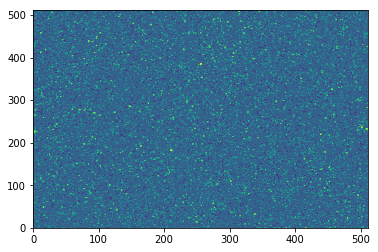

In [6]:
import matplotlib.pyplot as plt
Modelevolution=cupy.asnumpy(Modelevolution_device)
#fig=plt.figure()
plt.contourf(Modelevolution)
plt.show()
#plt.savefig('GPU.png',dpi=300)

In [3]:
#存图片的方法
im1=ax1.imshow(M_host.reshape(Size,Size), cmap=MusselMap, clim=(0, 1200), extent=[0,length,0,length]);
f1.savefig('fig/'+'Mussel'+"{:04d}".format(ii)+'.pdf', bbox_inches='tight')
f1.savefig('fig/'+'Mussel'+"{:04d}".format(ii)+'.png', bbox_inches='tight')

NameError: name 'ax1' is not defined